In [1]:
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from utils.dataio import *
from utils.visualization import *

DATA_DIR = '../data/'
RESULTS_DIR = '../results_new/numerical/'

In [2]:
# Load configuration file.
config = load_config('../config.yaml')

### Numerical phantom

In [3]:
ip_gt = load_mat(os.path.join(DATA_DIR, 'IP.mat'))
sos_gt = load_mat(os.path.join(DATA_DIR, 'SOS_easy.mat'))

ip_gt = standardize(ip_gt)
data_range_ip = 13 # ip_gt.max() - ip_gt.min()
data_range_sos = sos_gt.max() - sos_gt.min()

task_params = config['numerical']
IP_max, IP_min, SOS_max, SOS_min = task_params['IP_max'], task_params['IP_min'], task_params['SOS_max'], task_params['SOS_min']
norm_ip = Normalize(vmax=IP_max, vmin=IP_min)
norm_sos = Normalize(vmax=SOS_max, vmin=SOS_min)

#### Ground Truth

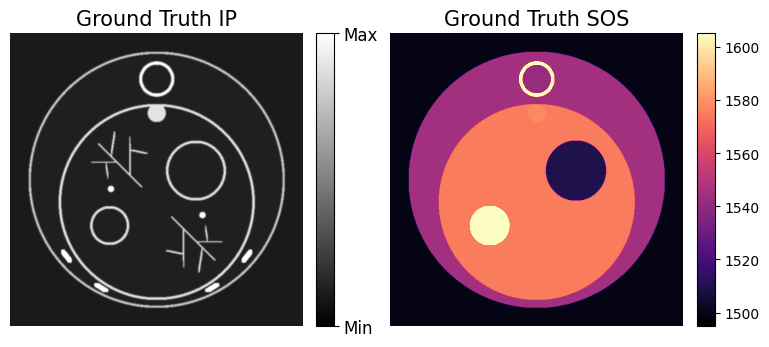

In [4]:
fig = plt.figure(figsize=(9, 3.8))
ax = plt.subplot(1,2,1)
plt.imshow(ip_gt, cmap='gray', norm=norm_ip)
plt.title('Ground Truth IP', fontsize=15)
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.02, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm_ip)
cb.set_ticks([IP_max, IP_min])
cb.set_ticklabels(['Max', 'Min'], fontsize=12)

ax = plt.subplot(1,2,2)
plt.imshow(sos_gt, cmap='magma', norm=norm_sos)
plt.title('Ground Truth SOS', fontsize=15)
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.02, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm_sos)

#### Delay-and-sum

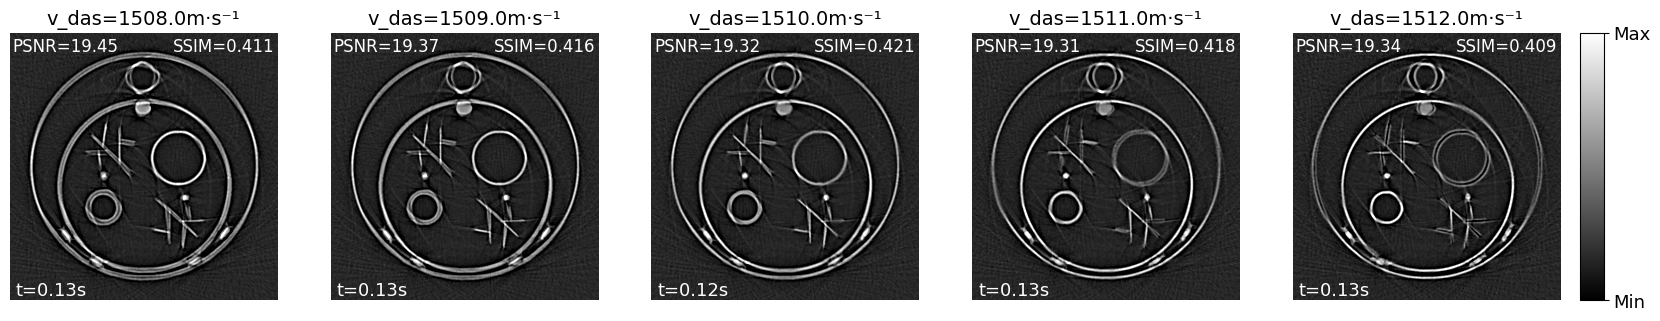

In [34]:
v_das_list = [1508, 1509, 1510, 1511, 1512]

fig = plt.figure(figsize=(20,5))
for idx, v_das in enumerate(v_das_list):
    params = 'v_das={:.1f}m·s⁻¹'.format(v_das)
    ip_rec = load_mat(os.path.join(RESULTS_DIR, 'DAS', params, 'IP_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(RESULTS_DIR, 'DAS', params, 'log.json'))
    ax = plt.subplot(1,5,idx+1)
    plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
    plt.axis('off')
    plt.title('v_das={:.1f}m·s⁻¹'.format(v_das), fontsize=14)
    plt.title('PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), loc='left', x=0.01, y=0.9, fontsize=12, color='white')
    plt.title('SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), loc='right', x=0.99, y=0.9, fontsize=12, color='white')
    plt.text(s='t={:.2f}s'.format(log['time']), x=12, y=550, fontsize=13, color='white')
    if idx == 4:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_ip)
        cb.set_ticks([IP_max, IP_min])
        cb.set_ticklabels(['Max', 'Min'], fontsize=13)

#### Dual-SOS DAS

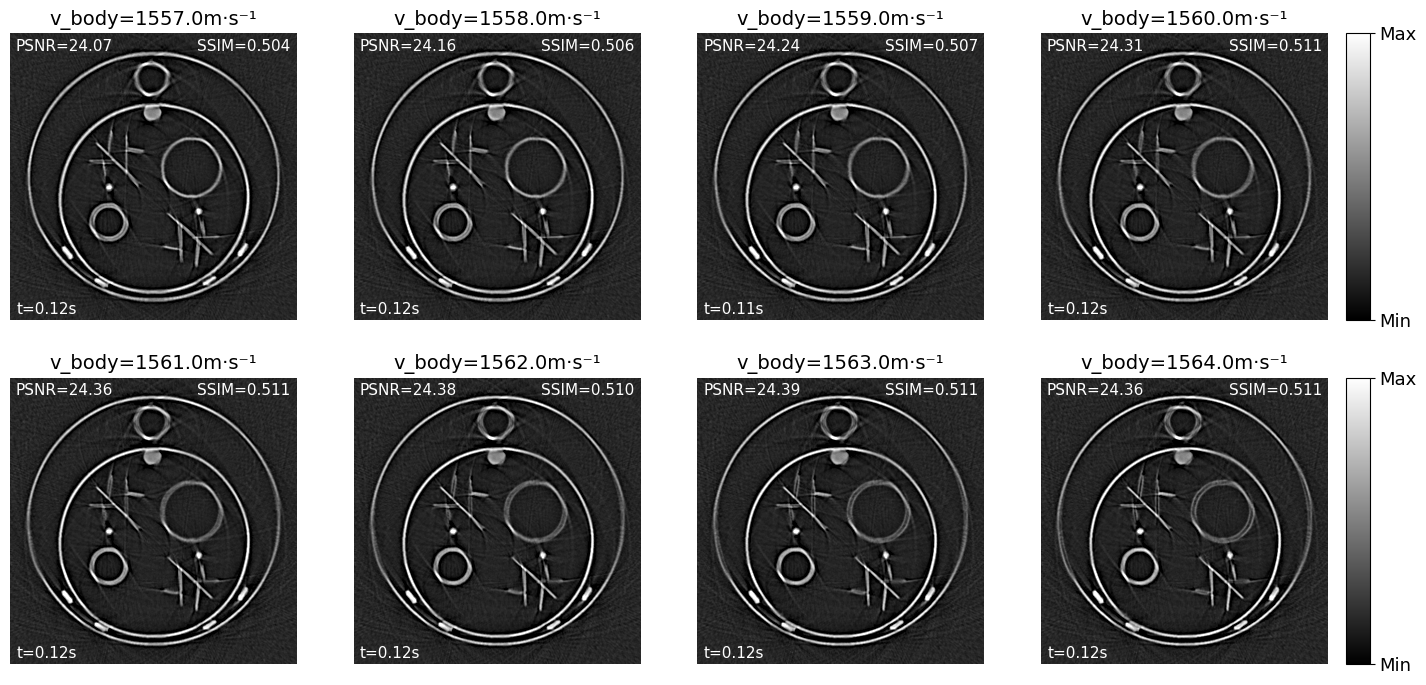

In [35]:
v_body_list = [1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564]

fig = plt.figure(figsize=(17,8.2))
for idx, v_body in enumerate(v_body_list):
    params = 'v_body={:.1f}m·s⁻¹'.format(v_body)
    ip_rec = load_mat(os.path.join(RESULTS_DIR, 'Dual-SOS_DAS', params, 'IP_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(RESULTS_DIR, 'Dual-SOS_DAS', params, 'log.json'))
    ax = plt.subplot(2,4,idx+1)
    plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
    plt.axis('off')
    plt.title('v_body={:.1f}m·s⁻¹'.format(v_body), fontsize=14)
    plt.title('PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), loc='left', x=0.02, y=0.91, fontsize=11, color='white')
    plt.title('SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), loc='right', x=0.98, y=0.91, fontsize=11, color='white')
    plt.text(s='t={:.2f}s'.format(log['time']), x=12, y=548, fontsize=11, color='white')
    if not (idx+1) % 4:
        cax = fig.add_axes([ax.get_position().x1+0.011, ax.get_position().y0, 0.014, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_ip)
        cb.set_ticks([IP_max, IP_min])
        cb.set_ticklabels(['Max', 'Min'], fontsize=13)

#### NF-APACT

Network structure (Positional encoding, number of hidden layers and hidden features).

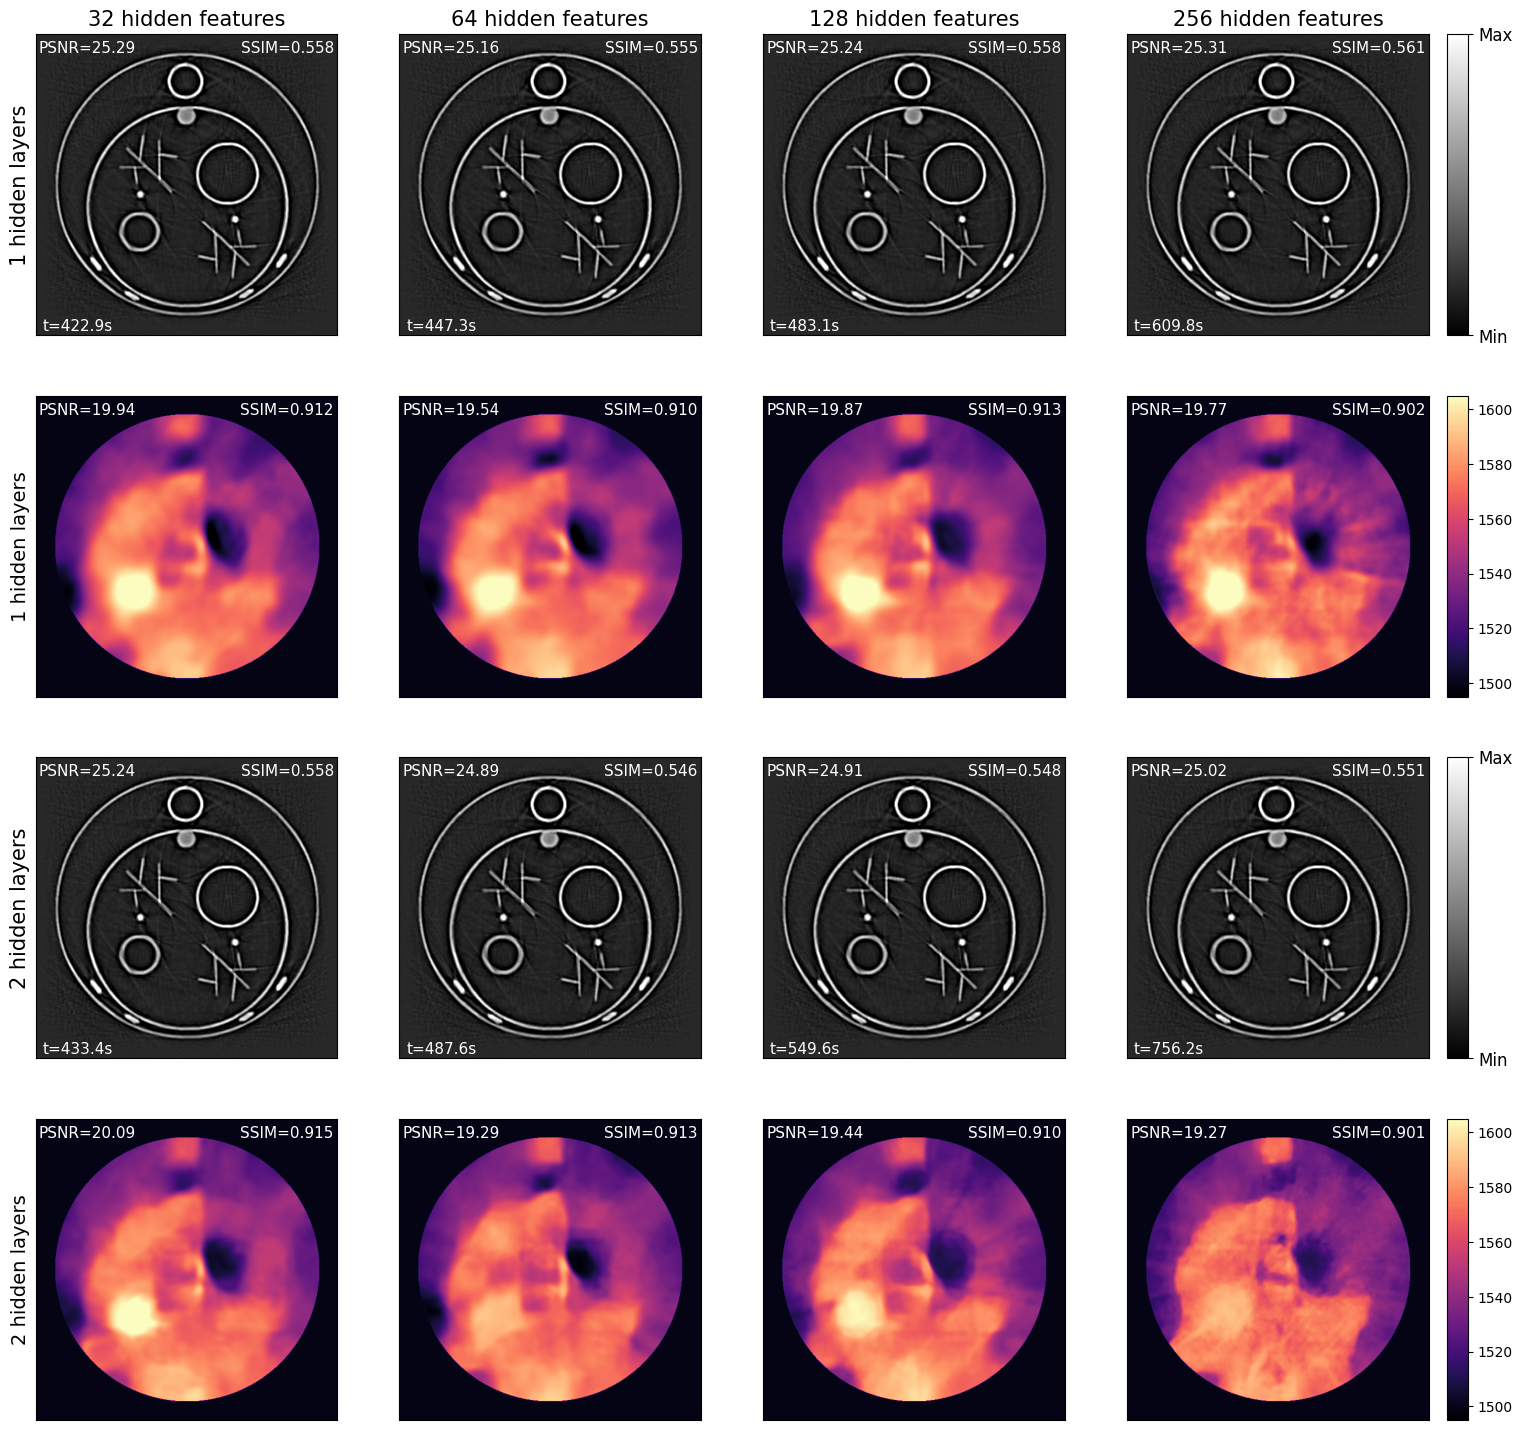

In [36]:
n_layers_list, n_hidden_fts_list = [1, 2], [32, 64, 128, 256]

fig = plt.figure(figsize=(18,18))
for i, n_hidden_fts in enumerate(n_hidden_fts_list):
    for j, n_layers in enumerate(n_layers_list):
        params = '{}delays_{}lyrs_{}fts_TV={:.1e}_{}epochs_bs={}_lr={:.1e}'.format(32, n_layers, n_hidden_fts, 5e-5, 10, 64, 1e-3)
        ip_rec = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'IP_rec.mat'))
        sos_rec = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'SOS_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'log.json'))
        ax = plt.subplot(2*len(n_layers_list),len(n_hidden_fts_list),i+1+len(n_hidden_fts_list)*2*j)
        plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
        plt.xticks([])
        plt.yticks([])
        plt.title('PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), loc='left', x=0.01, y=0.91, fontsize=11, color='white')
        plt.title('SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), loc='right', x=0.99, y=0.91, fontsize=11, color='white')
        plt.text(s='t={:.1f}s'.format(log['time']), x=12, y=550, fontsize=11, color='white')
        if j == 0:
            plt.title('{} hidden features'.format(n_hidden_fts), fontsize=15)
        if i == 0:
            plt.ylabel('{} hidden layers'.format(n_layers), fontsize=15)
        if (i+1) % len(n_hidden_fts_list) == 0:
            cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
            cb = plt.colorbar(cax=cax, norm=norm_ip)
            cb.set_ticks([IP_max, IP_min])
            cb.set_ticklabels(['Max', 'Min'], fontsize=12)
        
        ax = plt.subplot(2*len(n_layers_list),len(n_hidden_fts_list),i+1+len(n_hidden_fts_list)*(1+2*j))
        plt.imshow(sos_rec, cmap='magma', norm=norm_sos)
        plt.title('PSNR={:.2f}'.format(psnr(sos_gt, sos_rec, data_range=data_range_sos)), loc='left', x=0.01, y=0.91, fontsize=11, color='white')
        plt.title('SSIM={:.3f}'.format(ssim(sos_gt, sos_rec, data_range=data_range_sos)), loc='right', x=0.99, y=0.91, fontsize=11, color='white')
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel('{} hidden layers'.format(n_layers), fontsize=14)
        if (i+1) % len(n_hidden_fts_list) == 0:
            cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
            cb = plt.colorbar(cax=cax, norm=norm_sos)

Learning rate.


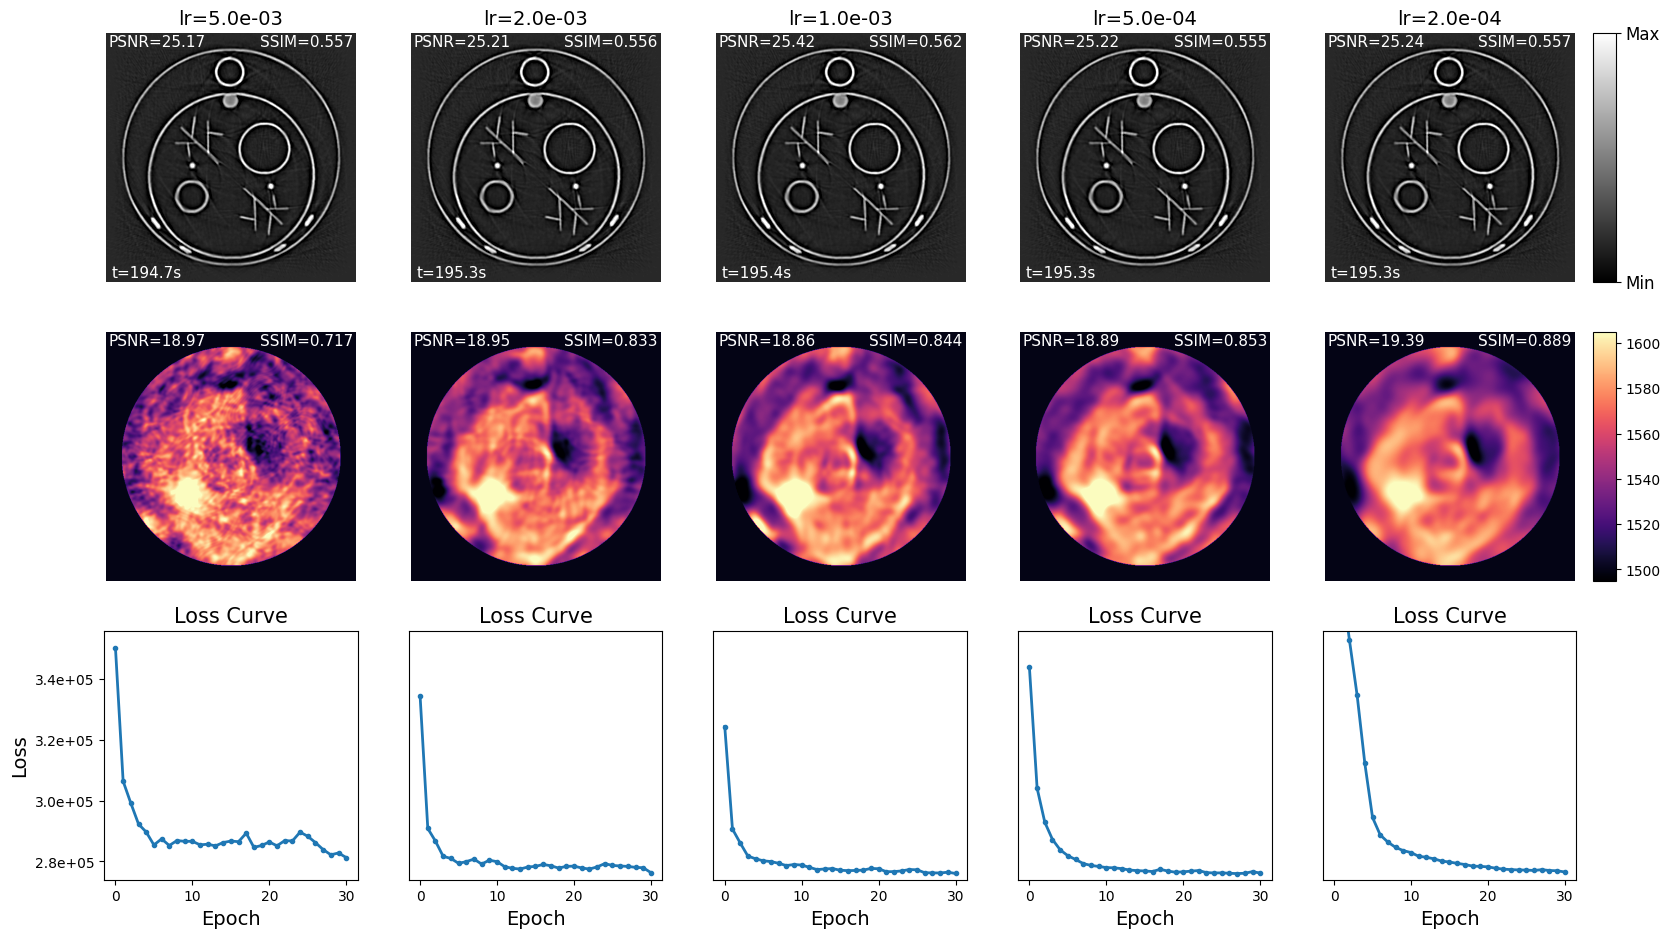

In [37]:
lr_list = [5e-3,2e-3,1e-3,5e-4,2e-4]

fig = plt.figure(figsize=(19,11))
for idx, lr in enumerate(lr_list):
    params = '{}delays_{}lyrs_{}fts_{}epochs_bs={}_lr={:.1e}'.format(32, 1, 64, 30, 64, lr)
    ip_rec = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'IP_rec.mat'))
    sos_rec = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'SOS_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'log.json'))
    ax = plt.subplot(3,len(lr_list),idx+1)
    plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
    plt.axis('off')
    plt.title('PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), loc='left', x=0.01, y=0.91, fontsize=11, color='white')
    plt.title('SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), loc='right', x=0.99, y=0.91, fontsize=11, color='white')
    plt.text(s='t={:.1f}s'.format(log['time']), x=12, y=550, fontsize=11, color='white')
    plt.title('lr={:.1e}'.format(lr), fontsize=14)
    if (idx+1) % len(lr_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_ip)
        cb.set_ticks([IP_max, IP_min])
        cb.set_ticklabels(['Max', 'Min'], fontsize=12)
    
    ax = plt.subplot(3,len(lr_list),idx+1+len(lr_list))
    plt.imshow(sos_rec, cmap='magma', norm=norm_sos)
    plt.title('PSNR={:.2f}'.format(psnr(sos_gt, sos_rec, data_range=data_range_sos)), loc='left', x=0.01, y=0.91, fontsize=11, color='white')
    plt.title('SSIM={:.3f}'.format(ssim(sos_gt, sos_rec, data_range=data_range_sos)), loc='right', x=0.99, y=0.91, fontsize=11, color='white')
    plt.axis('off')
    if (idx+1) % len(lr_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_sos)
        
    ax = plt.subplot(3,len(lr_list),idx+1+2*len(lr_list))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    plt.plot(range(len(log['loss'])), log['loss'], '-o', markersize=3, linewidth=2, label='loss')
    plt.ylim([2.74e5,3.56e5])
    plt.title("Loss Curve", fontsize=15)
    plt.xlabel("Epoch", fontsize=14)
    if idx == 0:
        plt.ylabel("Loss", fontsize=14)
    else:
        plt.yticks([],fontsize=9)

Number of delays.

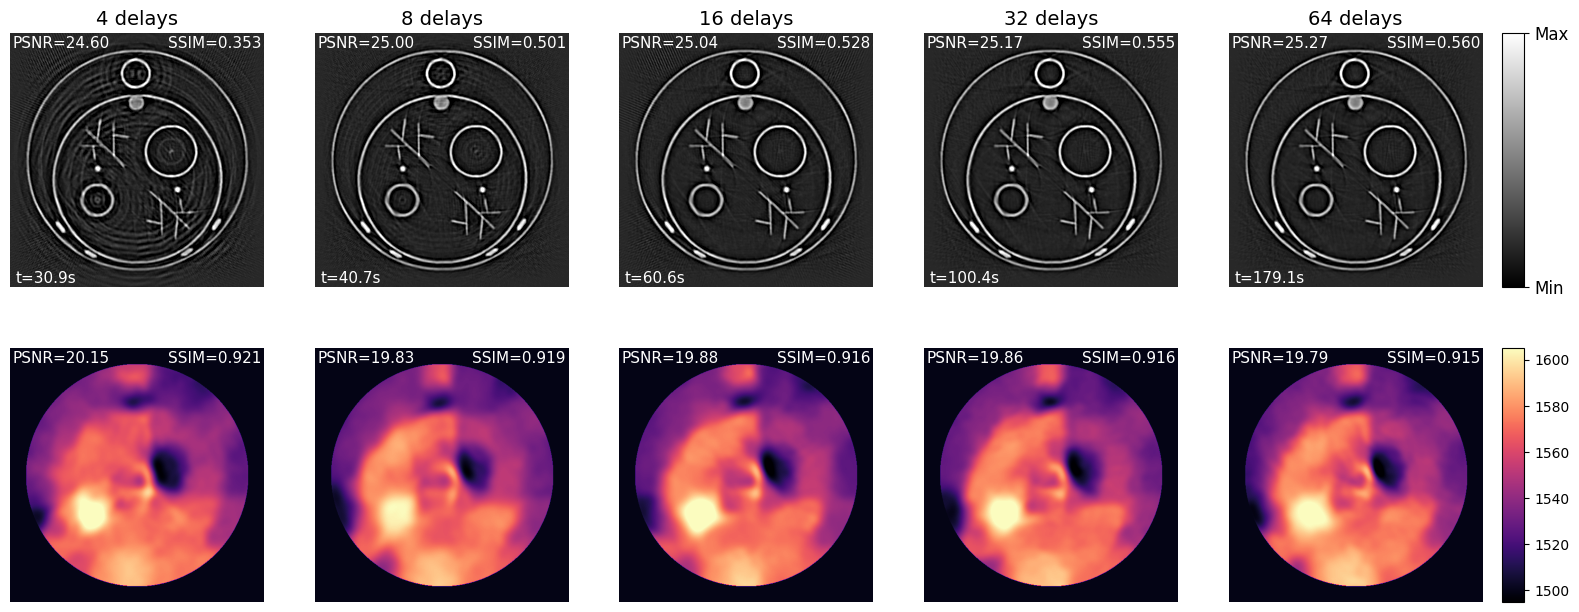

In [7]:
n_delays_list = [4, 8, 16, 32, 64]

fig = plt.figure(figsize=(19,7.5))
for idx, n_delays in enumerate(n_delays_list):
    params = '{}delays_{}lyrs_{}fts_TV={:.1e}_{}epochs_bs={}_lr={:.1e}'.format(n_delays, 1, 64, 5e-5, 15, 64, 1e-3)
    ip_rec = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'IP_rec.mat'))
    sos_rec = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'SOS_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'log.json'))
    ax = plt.subplot(2,len(n_delays_list),idx+1)
    plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
    plt.axis('off')
    plt.title('PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), loc='left', x=0.01, y=0.91, fontsize=11, color='white')
    plt.title('SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), loc='right', x=0.99, y=0.91, fontsize=11, color='white')
    plt.text(s='t={:.1f}s'.format(log['time']), x=12, y=550, fontsize=11, color='white')
    plt.title('{} delays'.format(n_delays), fontsize=14)
    if (idx+1) % len(n_delays_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_ip)
        cb.set_ticks([IP_max, IP_min])
        cb.set_ticklabels(['Max', 'Min'], fontsize=12)
    
    ax = plt.subplot(2,len(n_delays_list),idx+1+len(n_delays_list))
    plt.imshow(sos_rec, cmap='magma', norm=norm_sos)
    plt.title('PSNR={:.2f}'.format(psnr(sos_gt, sos_rec, data_range=data_range_sos)), loc='left', x=0.01, y=0.91, fontsize=11, color='white')
    plt.title('SSIM={:.3f}'.format(ssim(sos_gt, sos_rec, data_range=data_range_sos)), loc='right', x=0.99, y=0.91, fontsize=11, color='white')
    plt.axis('off')
    if (idx+1) % len(n_delays_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_sos)

#### TV Regularization.

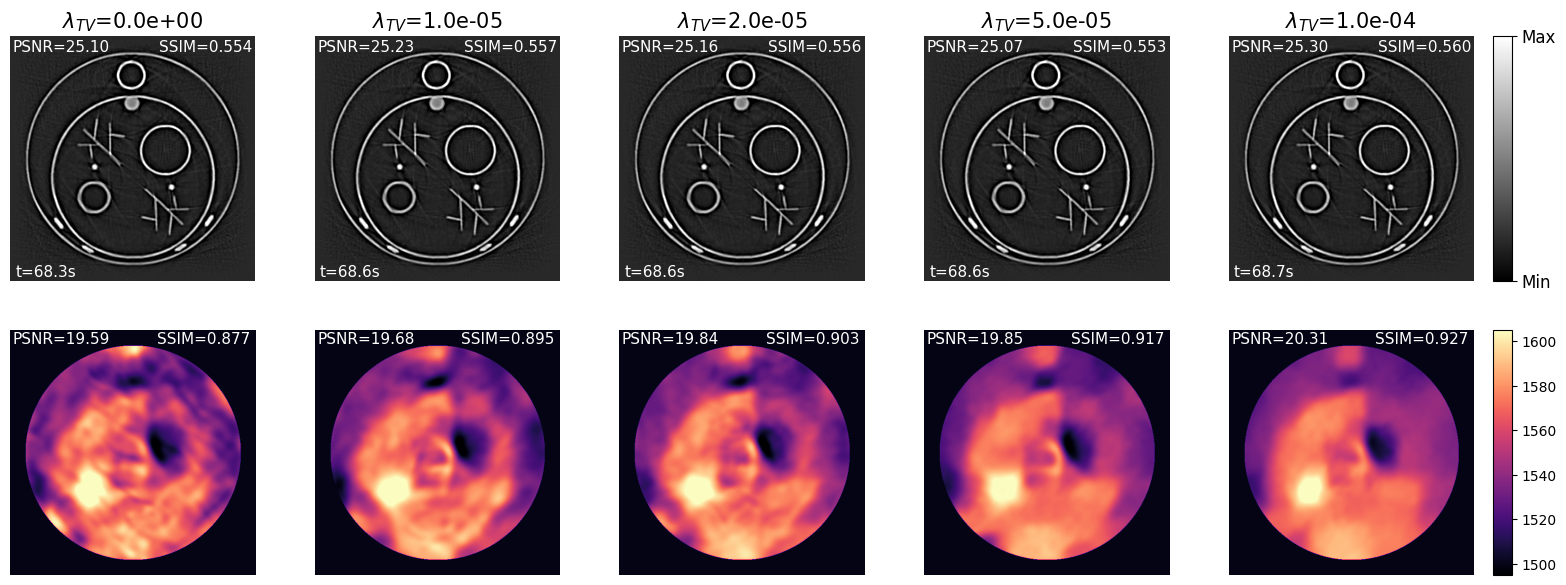

In [39]:
lam_list = [0.0, 1e-5, 2e-5, 5e-5, 1e-4]

fig = plt.figure(figsize=(19,7))

for i, lam in enumerate(lam_list):
    params =f'{32}delays_{1}lyrs_{64}fts' + ('_TV={:.1e}'.format(lam) if lam != 0 else '') + '_{}epochs_bs={}_lr={:.1e}'.format(10, 64, 1e-3)
    ip_rec = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'IP_rec.mat'))
    sos_rec = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'SOS_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(RESULTS_DIR, 'NF-APACT', params, 'log.json'))
    ax = plt.subplot(2,len(lam_list),i+1)
    plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
    plt.axis('off')
    plt.title('PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), loc='left', x=0.01, y=0.9, fontsize=11, color='white')
    plt.title('SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), loc='right', x=0.99, y=0.9, fontsize=11, color='white')
    plt.text(s='t={:.1f}s'.format(log['time']), x=12, y=550, fontsize=11, color='white')
    plt.title('$\lambda_{TV}$'+'={:.1e}'.format(lam), fontsize=15)

    if (i+1) % len(lam_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.01, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_ip)
        cb.set_ticks([IP_max, IP_min])
        cb.set_ticklabels(['Max', 'Min'], fontsize=12)
    
    ax = plt.subplot(2,len(lam_list),i+1+len(lam_list))
    plt.imshow(sos_rec, cmap='magma', norm=norm_sos)
    plt.title('PSNR={:.2f}'.format(psnr(sos_gt, sos_rec, data_range=data_range_sos)), loc='left', x=0.01, y=0.91, fontsize=11, color='white')
    plt.title('SSIM={:.3f}'.format(ssim(sos_gt, sos_rec, data_range=data_range_sos)), loc='right', x=0.98, y=0.91, fontsize=11, color='white')
    plt.axis('off')
    if (i+1) % len(lam_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.01, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_sos)